<h1 align="center" > Projeto final de sistema de recomendação de leads</h1>

In [3]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.cluster import KMeans

In [4]:
# Estilo seaborn
sns.set(style="whitegrid")

<h2 align="center" > Manipulando os dados</h2>

In [39]:
# Lendo os dados
portfolio1 = pd.read_csv('dados/estaticos_portfolio1.csv')
portfolio2 = pd.read_csv('dados/estaticos_portfolio2.csv')
portfolio3 = pd.read_csv('dados/estaticos_portfolio3.csv')
market = pd.read_csv('dados/estaticos_market.csv')

In [6]:
# Excluindo o índice Unnamed: 0 de todos os dataframes
portfolio1 = portfolio1.drop(['Unnamed: 0'], axis = 1)
portfolio2 = portfolio2.drop(['Unnamed: 0'], axis = 1)
portfolio3 = portfolio3.drop(['Unnamed: 0'], axis = 1)
market = market.drop(['Unnamed: 0'], axis = 1)

In [7]:
# Observando o tamanho e quantidade de colunas que cada dataframe tem
print('Shape do Portfolio1 é', portfolio1.shape)
print('Shape do Portfolio2 é', portfolio2.shape)
print('Shape do Portfolio3 é', portfolio3.shape)
print('Shape do Market é', market.shape)

Shape do Portfolio1 é (555, 181)
Shape do Portfolio2 é (566, 1)
Shape do Portfolio3 é (265, 1)
Shape do Market é (462298, 181)


### Market

In [9]:
market.head(3)

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,...,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [8]:
#Criando um dataframe auxliar para analisar a consistencia das variaveis
cons = pd.DataFrame({'colunas' : market.columns,
                    'tipo': market.dtypes,
                    'missing' : market.isna().sum(),
                    'size' : market.shape[0],
                  'unicos': market.nunique()})
cons['percentual'] = round(cons['missing'] / cons['size'],2)

In [9]:
cons.head()

,colunas,tipo,missing,size,unicos,percentual
id,id,object,0,462298,462298,0.0
fl_matriz,fl_matriz,bool,0,462298,2,0.0
de_natureza_juridica,de_natureza_juridica,object,0,462298,67,0.0
sg_uf,sg_uf,object,0,462298,6,0.0
natureza_juridica_macro,natureza_juridica_macro,object,0,462298,7,0.0


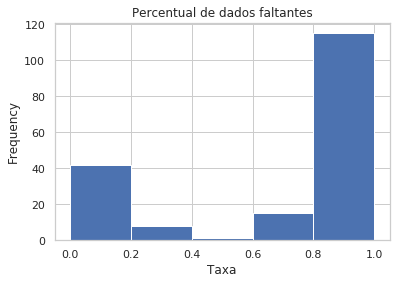

In [10]:
sns.set_style('whitegrid')
cons.percentual.plot.hist( bins = 5)
plt.xlabel("Taxa")
plt.title("Percentual de dados faltantes")
plt.show()

#### Removendo as colunas com muitos dados faltantes

In [13]:
# Dúvida
print('Contagem de colunas com ATÉ 70% de dados faltantes', cons[cons.percentual <= 0.7].shape[0])
print('Contagem de colunas com 0% de dados faltantes',  cons[cons.percentual == 0].shape[0])

Contagem de colunas com ATÉ 70% de dados faltantes 52
Contagem de colunas com 0% de dados faltantes 30


In [14]:
# Contagem do tipo de dados que tem poucos dados faltantes
cons[cons.percentual <= 0.7]['tipo'].value_counts()

object     26
float64    16
bool        9
int64       1
Name: tipo, dtype: int64

In [15]:
cons[cons.percentual <= 0]['tipo'].value_counts()

object     17
bool        9
float64     3
int64       1
Name: tipo, dtype: int64

In [16]:
cons['completa'] = ['completa' if x == 0 else 'faltante' for x in cons['percentual']]
cons['setenta'] = ['setenta' if x <= 0.70 else 'remover' for x in cons['percentual']]

In [17]:
# Visualizando os dados
cons.head()

,colunas,tipo,missing,size,unicos,percentual,completa,setenta
id,id,object,0,462298,462298,0.0,completa,setenta
fl_matriz,fl_matriz,bool,0,462298,2,0.0,completa,setenta
de_natureza_juridica,de_natureza_juridica,object,0,462298,67,0.0,completa,setenta
sg_uf,sg_uf,object,0,462298,6,0.0,completa,setenta
natureza_juridica_macro,natureza_juridica_macro,object,0,462298,7,0.0,completa,setenta


In [18]:
mantem = list(cons[cons['setenta'] == 'setenta']['colunas'])
market_clean = market[mantem]

In [19]:
# Colunas selecionadas pelo critério de acima de 70% de dados faltantes
market_clean.columns

Index(['id', 'fl_matriz', 'de_natureza_juridica', 'sg_uf',
       'natureza_juridica_macro', 'de_ramo', 'setor', 'idade_empresa_anos',
       'idade_emp_cat', 'fl_me', 'fl_sa', 'fl_epp', 'fl_mei', 'fl_ltda',
       'dt_situacao', 'fl_st_especial', 'fl_email', 'fl_telefone', 'fl_rm',
       'nm_divisao', 'nm_segmento', 'fl_spa', 'fl_antt', 'fl_veiculo',
       'fl_optante_simples', 'vl_total_veiculos_pesados_grupo',
       'vl_total_veiculos_leves_grupo', 'fl_optante_simei', 'sg_uf_matriz',
       'de_saude_tributaria', 'de_saude_rescencia', 'nu_meses_rescencia',
       'de_nivel_atividade', 'fl_simples_irregular',
       'empsetorcensitariofaixarendapopulacao', 'nm_meso_regiao',
       'nm_micro_regiao', 'fl_passivel_iss', 'qt_socios', 'qt_socios_pf',
       'qt_socios_pj', 'idade_media_socios', 'idade_maxima_socios',
       'idade_minima_socios', 'qt_socios_st_regular', 'qt_socios_masculino',
       'qt_socios_feminino', 'de_faixa_faturamento_estimado',
       'de_faixa_faturamento_es

In [20]:
# Visualiza sem os ... das colunas
pd.set_option('display.max_columns', 500)

In [21]:
market_clean.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,dt_situacao,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,fl_simples_irregular,empsetorcensitariofaixarendapopulacao,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,qt_socios_masculino,qt_socios_feminino,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,False,False,False,2005-03-25,False,True,True,SIM,CONSTRUCAO DE EDIFICIOS,CONSTRUCAO,False,False,False,True,0.0,0.0,False,RN,VERDE,ACIMA DE 1 ANO,23.0,ALTA,False,NaN,LESTE POTIGUAR,NATAL,True,2.0,2.0,0.0,44.0,47.0,41.0,2.0,2.0,NaN,"DE R$ 1.500.000,01 A R$ 4.800.000,00","DE R$ 1.500.000,01 A R$ 4.800.000,00",3132172.8,3132172.8,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,False,False,True,False,2017-05-12,False,True,True,SIM,ALIMENTACAO,ALOJAMENTO E ALIMENTACAO,False,False,False,NaN,0.0,0.0,NaN,PI,CINZA,ATE 1 ANO,9.0,BAIXA,False,468.93,CENTRO NORTE PIAUIENSE,TERESINA,True,1.0,1.0,0.0,27.0,27.0,27.0,1.0,1.0,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,False,False,True,False,2011-09-26,False,False,True,SIM,TRANSPORTE TERRESTRE,TRANSPORTE ARMAZENAGEM E CORREIO,False,False,False,True,0.0,0.0,True,AM,AMARELO,ACIMA DE 1 ANO,26.0,MEDIA,False,713.50,CENTRO AMAZONENSE,MANAUS,True,1.0,1.0,0.0,32.0,32.0,32.0,NaN,1.0,NaN,"ATE R$ 81.000,00","ATE R$ 81.000,00",50000.0,50000.0,0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,False,False,False,False,2012-04-25,False,True,True,SIM,REPARACAO E MANUTENCAO DE EQUIPAMENTOS DE INFO...,OUTRAS ATIVIDADES DE SERVICOS,False,False,False,True,0.0,0.0,False,AM,AMARELO,ACIMA DE 1 ANO,26.0,MEDIA,False,475.73,CENTRO AMAZONENSE,MANAUS,True,1.0,1.0,0.0,36.0,36.0,36.0,1.0,1.0,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0,0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,False,False,False,False,2015-08-17,False,True,True,SIM,SERVICOS DE ARQUITETURA E ENGENHARIA TESTES E ...,ATIVIDADES PROFISSIONAIS CIENTIFICAS E TECNICAS,False,False,False,True,0.0,0.0,False,RN,VERDE,ACIMA DE 1 ANO,27.0,ALTA,False,2874.04,LESTE POTIGUAR,NATAL,True,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0,0


In [22]:
market_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462298 entries, 0 to 462297
Data columns (total 52 columns):
id                                       462298 non-null object
fl_matriz                                462298 non-null bool
de_natureza_juridica                     462298 non-null object
sg_uf                                    462298 non-null object
natureza_juridica_macro                  462298 non-null object
de_ramo                                  462298 non-null object
setor                                    460371 non-null object
idade_empresa_anos                       462298 non-null float64
idade_emp_cat                            462298 non-null object
fl_me                                    462298 non-null bool
fl_sa                                    462298 non-null bool
fl_epp                                   462298 non-null bool
fl_mei                                   462298 non-null bool
fl_ltda                                  462298 non-null bool
dt_s

In [23]:
# Criando lista auxiliares com nomes de coluns
colunas_numericas = list(cons[((cons['tipo'] != 'object') &
                              (cons['setenta'] == 'setenta') & (cons['tipo'] != 'bool'))]['colunas']) 
colunas_categoricas = list(cons[((cons['tipo'] == 'object') &
                                (cons['setenta'] == 'setenta'))]['colunas'])
colunas_poucascategorias = list(cons[((cons['tipo'] == 'object')  &
                                     (cons['setenta'] == 'setenta') & 
                                    (cons['unicos'] < 9))]['colunas'])

In [24]:
colunas_numericas

['idade_empresa_anos',
 'vl_total_veiculos_pesados_grupo',
 'vl_total_veiculos_leves_grupo',
 'nu_meses_rescencia',
 'empsetorcensitariofaixarendapopulacao',
 'qt_socios',
 'qt_socios_pf',
 'qt_socios_pj',
 'idade_media_socios',
 'idade_maxima_socios',
 'idade_minima_socios',
 'qt_socios_st_regular',
 'qt_socios_masculino',
 'qt_socios_feminino',
 'vl_faturamento_estimado_aux',
 'vl_faturamento_estimado_grupo_aux',
 'qt_filiais']

#### Analisando as correlações entre variavéis

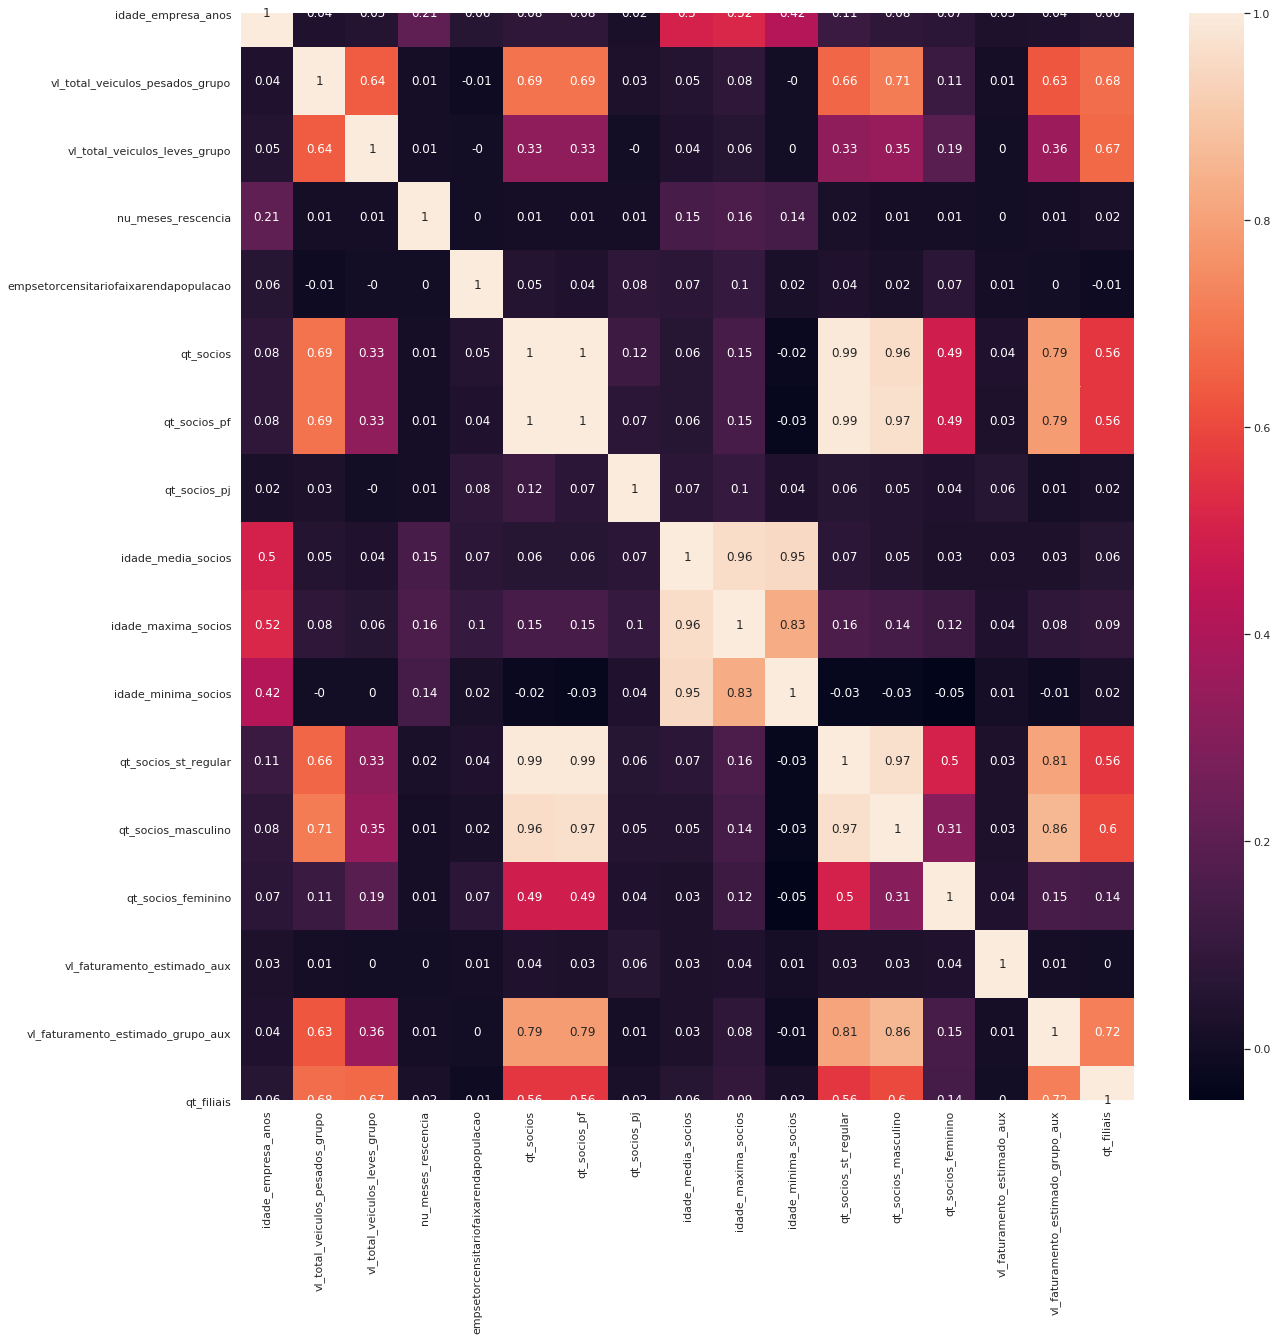

In [227]:
#Analisando a correlacao entre as variaveis númericas
plt.figure(figsize = (20,20))
sns.heatmap(market_clean[colunas_numericas].corr().round(2), annot= True)
plt.show()

In [25]:
market_clean.select_dtypes(bool).head()

,fl_matriz,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone
0,True,False,False,False,False,False,False,True,True
1,True,False,False,False,True,False,False,True,True
2,True,False,False,False,True,False,False,False,True
3,True,False,False,False,False,False,False,True,True
4,True,False,False,False,False,False,False,True,True


In [26]:
# Trocando os valores das variáveis para números binários
market_clean = market_clean.applymap(lambda x: 1 if x == True else x)
market_clean = market_clean.applymap(lambda x: 0 if x == False else x)

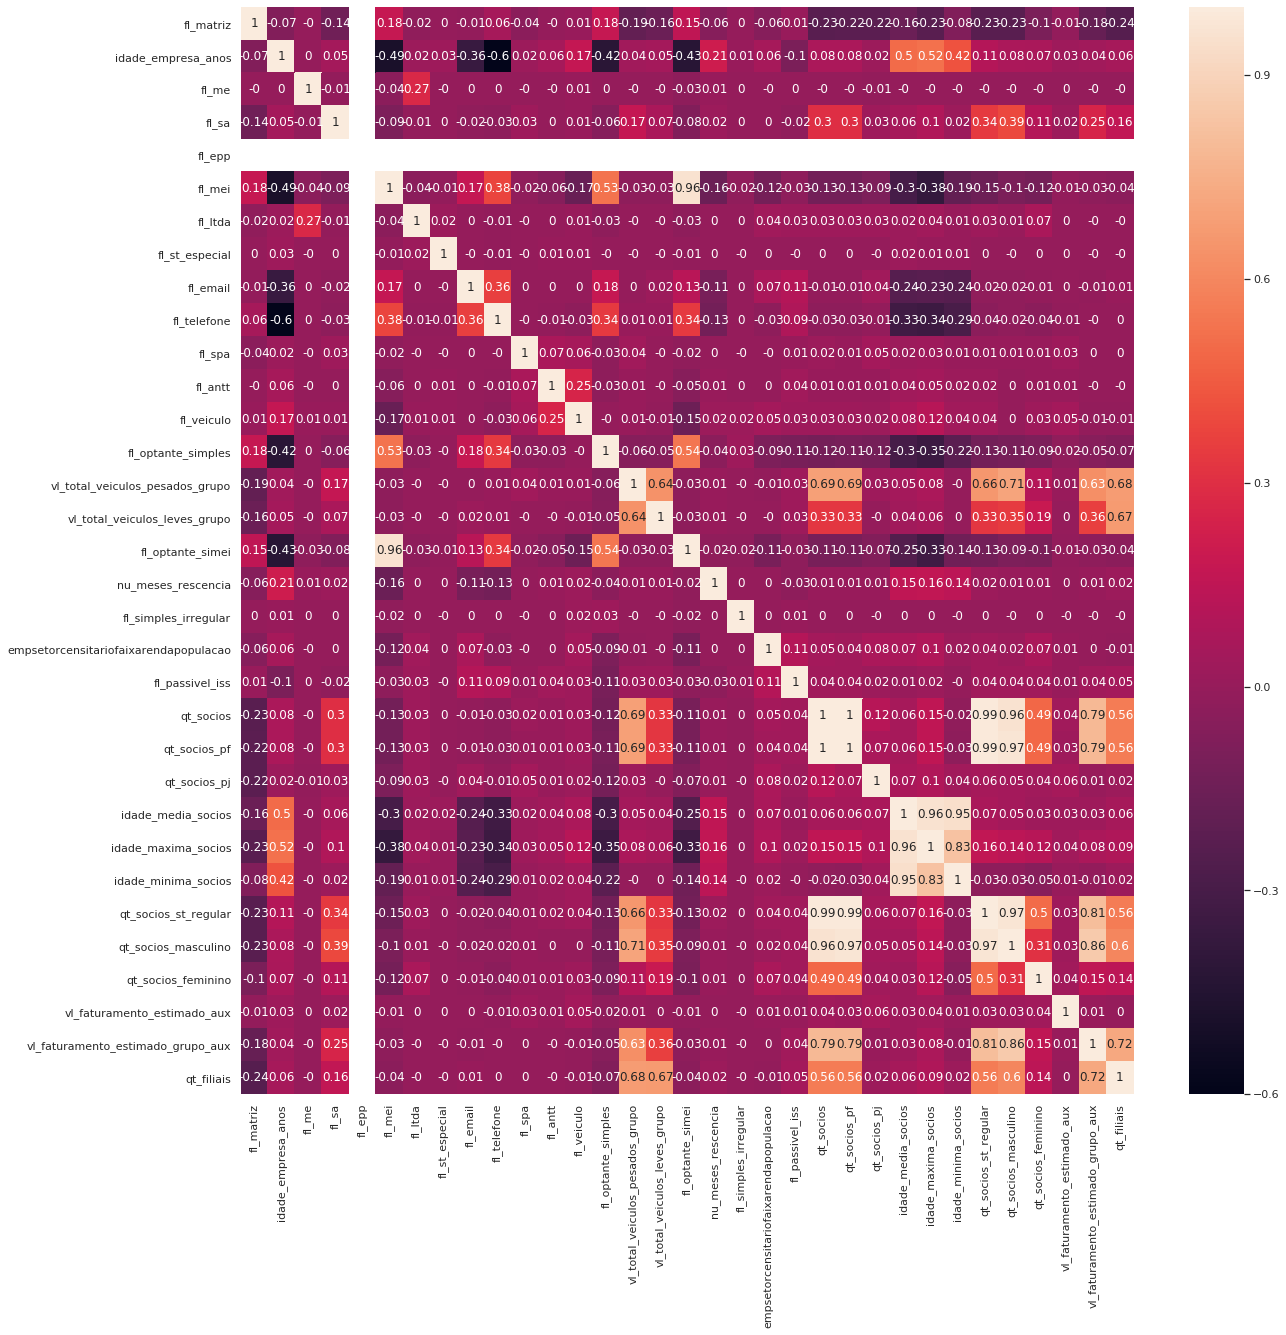

In [27]:
plt.figure(figsize = (20,20))
sns.heatmap(market_clean.corr().round(2), annot= True)
plt.show()

In [28]:
# Excluindo esta variavél porque na correlação ela fica totalmente em branco
market_clean.drop('fl_epp', axis=1, inplace=True)

In [29]:
#Mapeando a variável ao invés de sim ou não, deixar ela numérica
market_clean['fl_rm'] = market_clean['fl_rm'].map({'SIM': 1, 'NAO': 0})

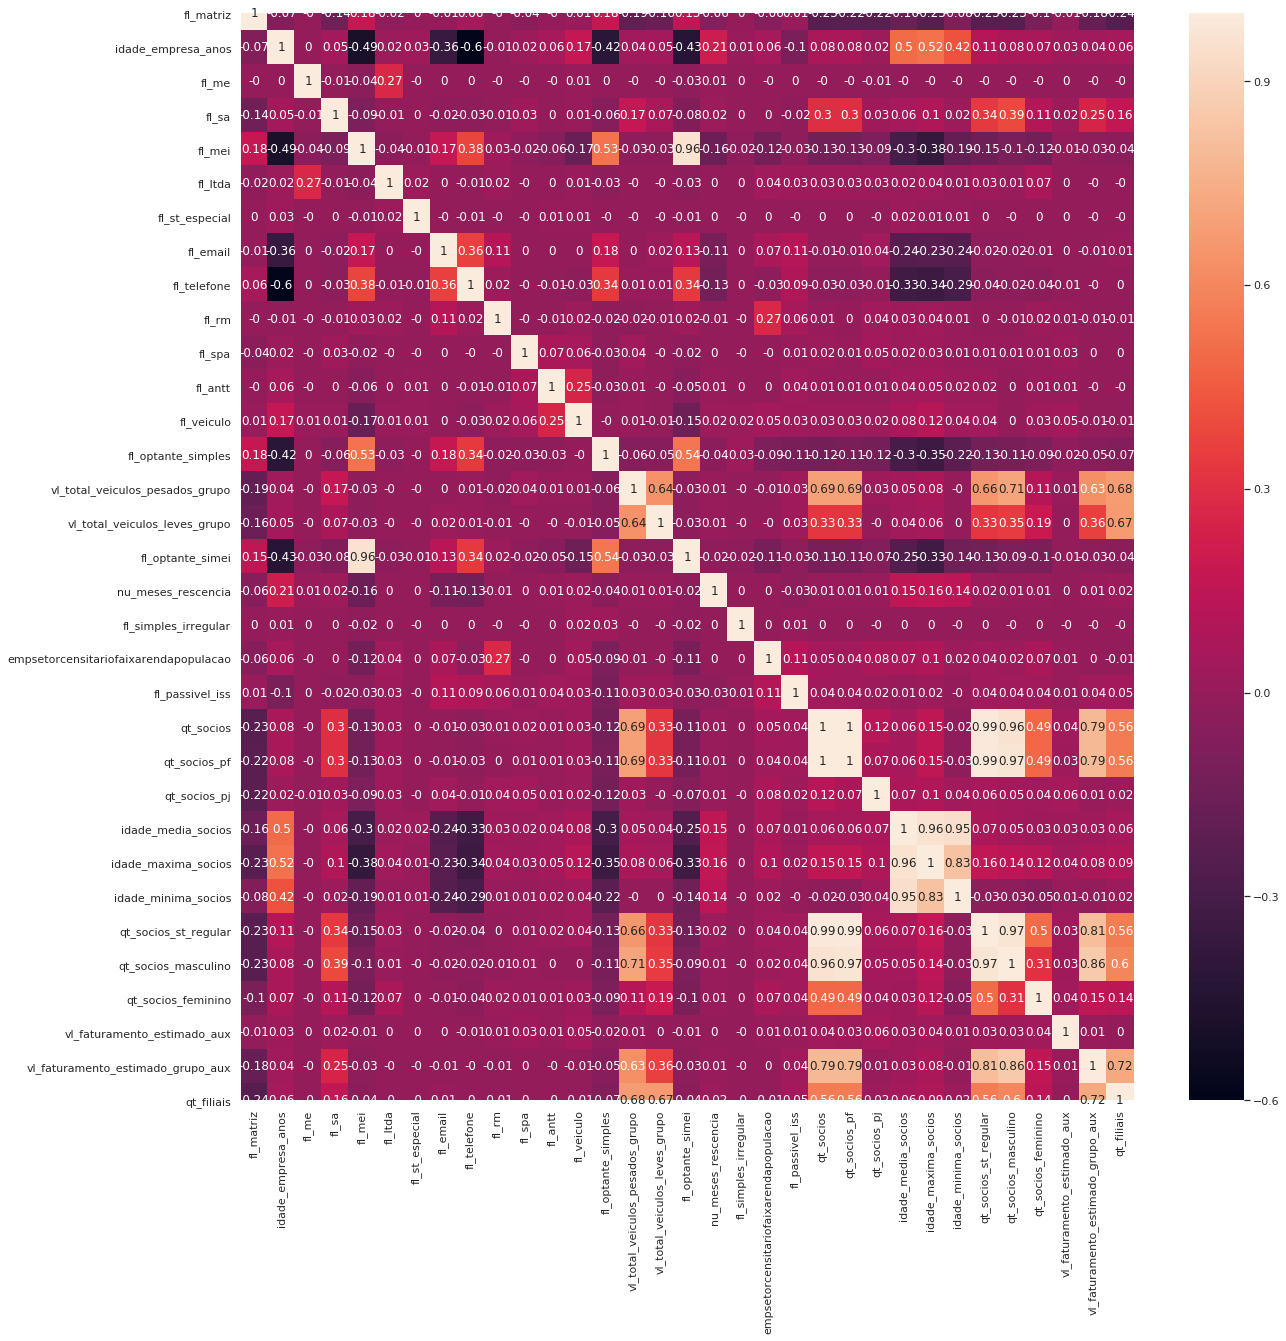

In [233]:
plt.figure(figsize = (20,20))
sns.heatmap(market_clean.corr().round(2), annot= True)
plt.show()

### Visão geral do Market com o pandas profiling

In [ ]:
import pandas_profiling

In [ ]:
market_clean_profile = market_clean.profile_report(style={'full_width':True}, title='Pandas Profiling Report',check_recoded = False)

In [ ]:
market_clean_profile.to_file(output_file="Profile.html")

#### Tirando as features de acordo com o pandas profiling 

In [30]:
# Tirando as features de acordo com o pandas profiling 
market_clean.drop(['fl_optante_simei', 'idade_maxima_socios','idade_minima_socios','qt_socios_pf','qt_socios_st_regular', 'qt_socios_masculino'],
                 axis=1,inplace=True)

In [29]:
# Observando variáveis específicas
print(market_clean['fl_veiculo'].value_counts())
print(market_clean['fl_spa'].value_counts())
print(market_clean['fl_antt'].value_counts())

0.0    429687
1.0     30684
Name: fl_veiculo, dtype: int64
0.0    460091
1.0       280
Name: fl_spa, dtype: int64
0.0    457095
1.0      3276
Name: fl_antt, dtype: int64


In [31]:
# Excluindo porque estas variáveis são muitos específicas
market_clean.drop(['fl_antt', 'fl_veiculo', 'qt_socios_pj'], axis=1, inplace=True)

In [32]:
market_clean.drop(['fl_spa', 'fl_simples_irregular'], axis=1, inplace=True)

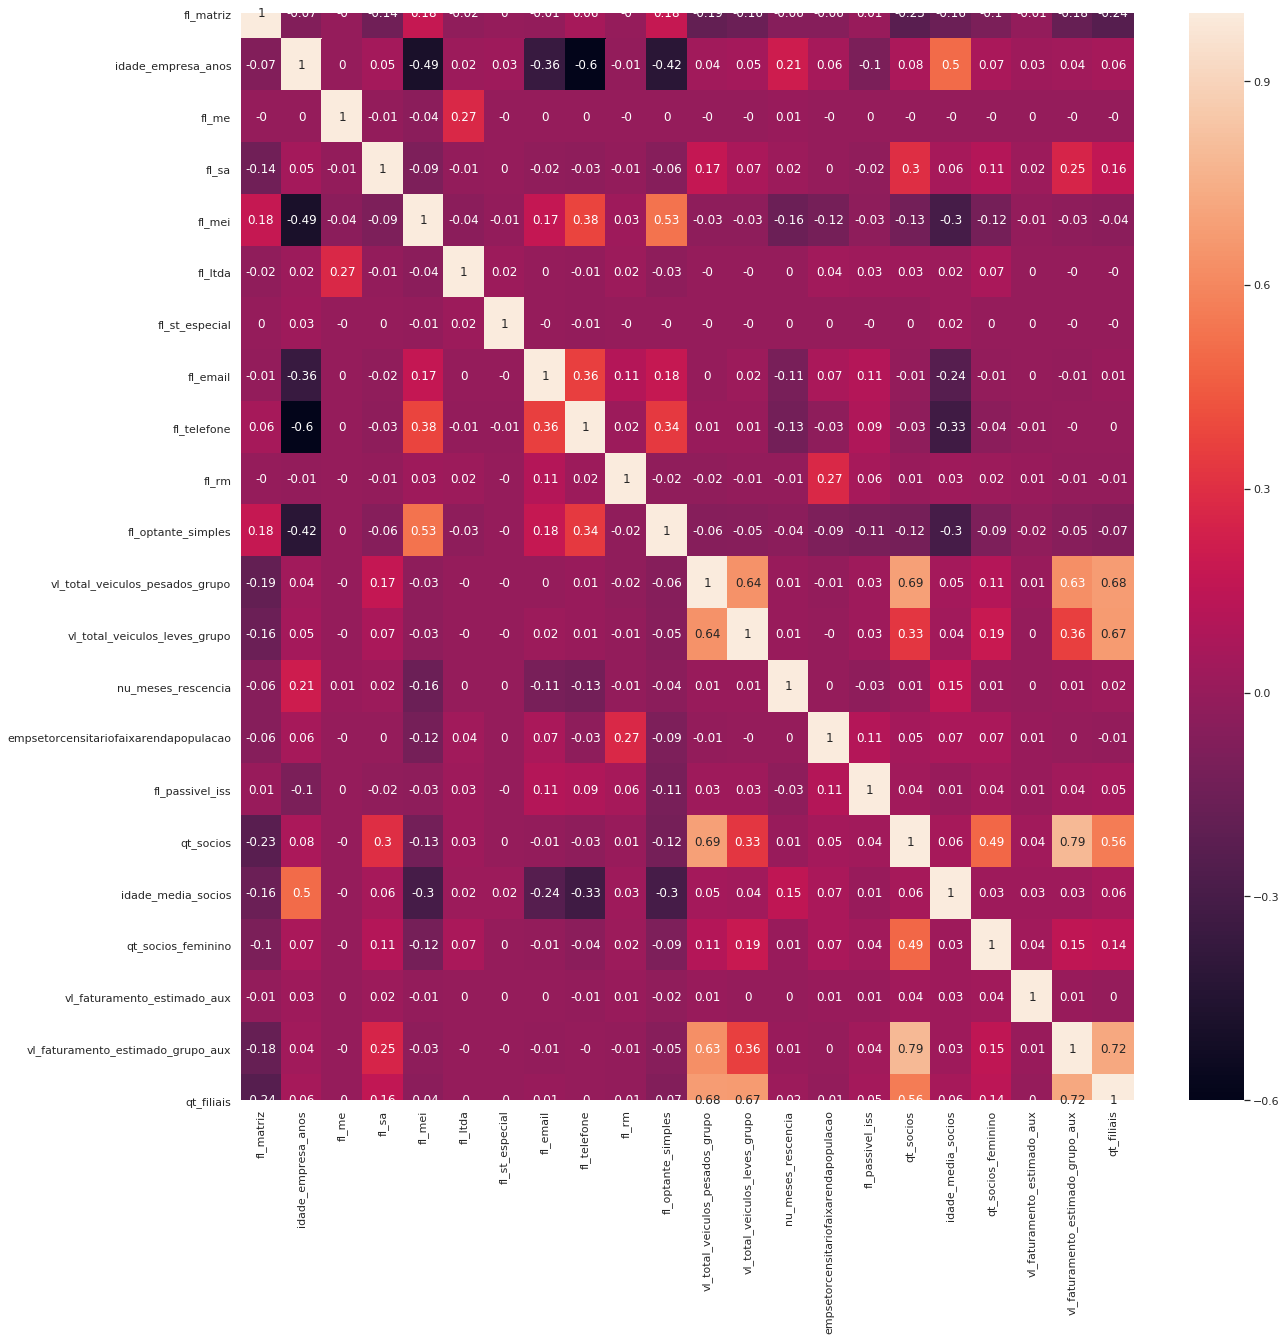

In [238]:
plt.figure(figsize = (20,20))
sns.heatmap(market_clean.corr().round(2), annot= True)

In [33]:
# Removendo as variáveis que 
colunas_numericas.remove('qt_socios_pj')
colunas_numericas.remove('idade_maxima_socios')
colunas_numericas.remove('idade_minima_socios')
colunas_numericas.remove('qt_socios_st_regular')

In [34]:
colunas_numericas.remove('qt_socios_masculino')

In [35]:
market_clean.shape

(462298, 40)

In [36]:
market_clean['fl_email'] = market_clean['fl_email'].astype(bool)
market_clean['fl_ltda'] = market_clean['fl_ltda'].astype(bool)
market_clean['fl_matriz'] = market_clean['fl_matriz'].astype(bool)
market_clean['fl_me'] = market_clean['fl_me'].astype(bool)
market_clean['fl_mei'] = market_clean['fl_mei'].astype(bool)
market_clean['fl_optante_simples'] = market_clean['fl_optante_simples'].astype(bool)
market_clean['fl_passivel_iss'] = market_clean['fl_passivel_iss'].astype(bool)
market_clean['fl_rm'] = market_clean['fl_rm'].astype(bool)
market_clean['fl_sa'] = market_clean['fl_sa'].astype(bool)
market_clean['fl_st_especial'] = market_clean['fl_st_especial'].astype(bool)
market_clean['fl_telefone'] = market_clean['fl_telefone'].astype(bool)

In [37]:
market_clean.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_mei,fl_ltda,dt_situacao,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_optante_simples,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,empsetorcensitariofaixarendapopulacao,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios,idade_media_socios,qt_socios_feminino,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,False,False,2005-03-25,False,True,True,True,CONSTRUCAO DE EDIFICIOS,CONSTRUCAO,True,0.0,0.0,RN,VERDE,ACIMA DE 1 ANO,23.0,ALTA,NaN,LESTE POTIGUAR,NATAL,True,2.0,44.0,NaN,"DE R$ 1.500.000,01 A R$ 4.800.000,00","DE R$ 1.500.000,01 A R$ 4.800.000,00",3132172.8,3132172.8,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,False,True,False,2017-05-12,False,True,True,True,ALIMENTACAO,ALOJAMENTO E ALIMENTACAO,True,0.0,0.0,PI,CINZA,ATE 1 ANO,9.0,BAIXA,468.93,CENTRO NORTE PIAUIENSE,TERESINA,True,1.0,27.0,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,False,True,False,2011-09-26,False,False,True,True,TRANSPORTE TERRESTRE,TRANSPORTE ARMAZENAGEM E CORREIO,True,0.0,0.0,AM,AMARELO,ACIMA DE 1 ANO,26.0,MEDIA,713.50,CENTRO AMAZONENSE,MANAUS,True,1.0,32.0,NaN,"ATE R$ 81.000,00","ATE R$ 81.000,00",50000.0,50000.0,0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,False,False,False,2012-04-25,False,True,True,True,REPARACAO E MANUTENCAO DE EQUIPAMENTOS DE INFO...,OUTRAS ATIVIDADES DE SERVICOS,True,0.0,0.0,AM,AMARELO,ACIMA DE 1 ANO,26.0,MEDIA,475.73,CENTRO AMAZONENSE,MANAUS,True,1.0,36.0,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0,0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,False,False,False,2015-08-17,False,True,True,True,SERVICOS DE ARQUITETURA E ENGENHARIA TESTES E ...,ATIVIDADES PROFISSIONAIS CIENTIFICAS E TECNICAS,True,0.0,0.0,RN,VERDE,ACIMA DE 1 ANO,27.0,ALTA,2874.04,LESTE POTIGUAR,NATAL,True,1.0,NaN,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0,0


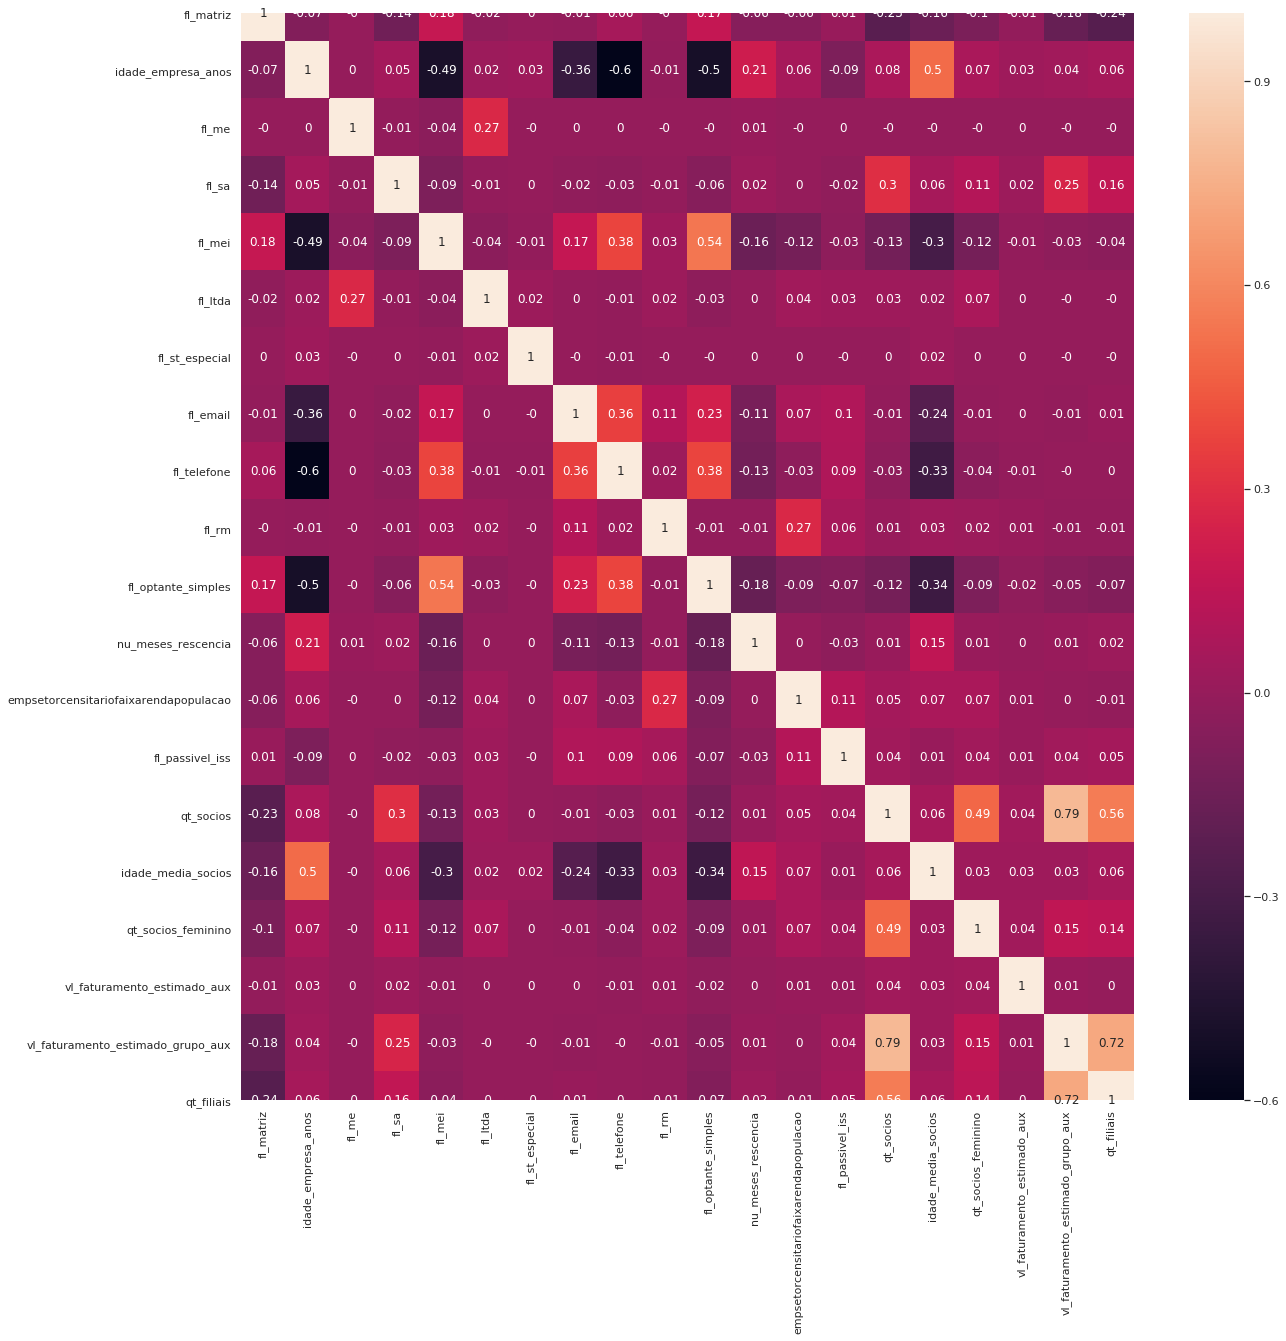

In [253]:
plt.figure(figsize = (20,20))
sns.heatmap(market_clean.corr().round(2), annot= True)
plt.show()

<h2 align="center" > Análise exploratória</h2>

In [37]:
def graph_barras_abs(df,atributo,rotulox,titulo,altura,largura):
    df1=df
    df1 = df1.reset_index(drop=True)
    df1 = df1.groupby(atributo).size().reset_index(name='counts')
    n = df1[atributo].unique().__len__()+1
    all_colors = list(plt.cm.colors.cnames.keys())
    random.seed(100)
    c = random.choices(all_colors, k=n)
    df1= df1.sort_values(by='counts',ascending=True)
    df1 = df1.set_index(atributo)
    df1.counts.plot.bar(figsize=(largura,altura),width=0.5,color=c)
    for i, val in enumerate(df1['counts'].values):
        plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':100, 'size':9})
    
    plt.title(titulo)
    plt.yscale('log')
    plt.xlabel(rotulox)
    plt.ylabel('Frequência')
    plt.show()

#### Analisando variáveis categóricas

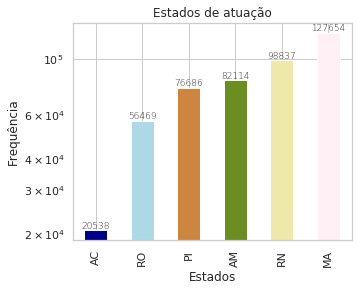

In [255]:
# As três regiões que tem mais empresas são
graph_barras_abs(market_clean,'sg_uf','Estados','Estados de atuação',4,5)

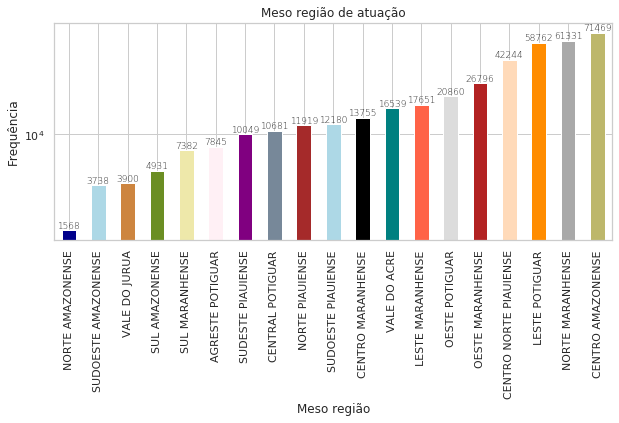

In [256]:
# No centro amazonense, norte maranhense e leste potiguar são as regiões que possuem mais atuação
graph_barras_abs(market_clean,'nm_meso_regiao','Meso região','Meso região de atuação',4,10)

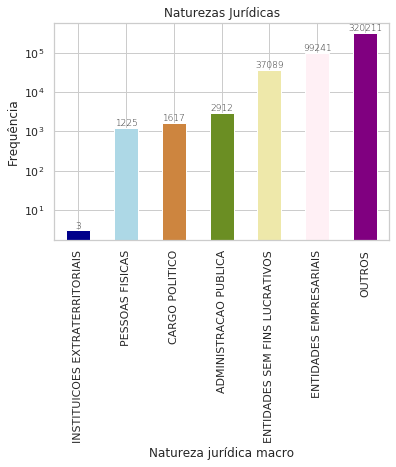

In [257]:
# A maioria das empresas são de empresariais ou não classificada
graph_barras_abs(market_clean,'natureza_juridica_macro','Natureza jurídica macro','Naturezas Jurídicas',4,6)

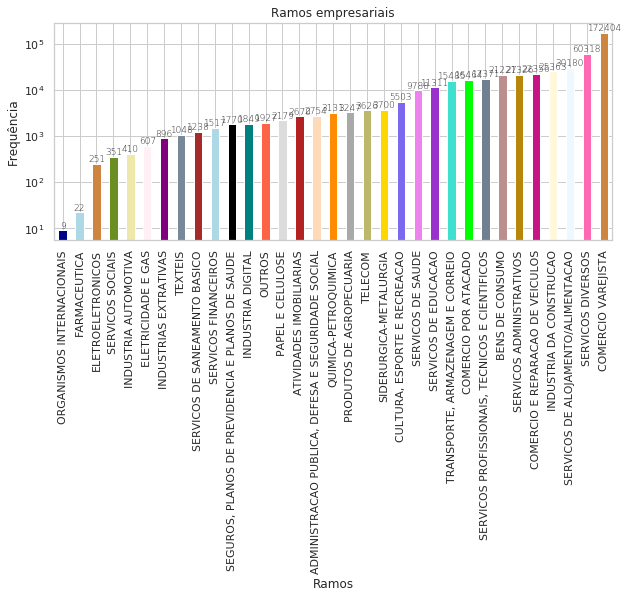

In [258]:
# O ramo de maior atuação é do comércio varejista
graph_barras_abs(market_clean,'de_ramo','Ramos','Ramos empresariais',4,10)

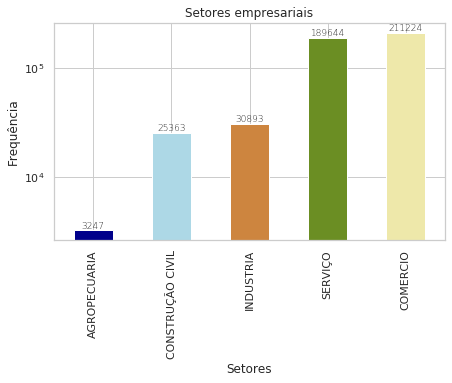

In [259]:
# A maioria das empresas estão no ramo de comércio
graph_barras_abs(market_clean,'setor','Setores','Setores empresariais',4,7)

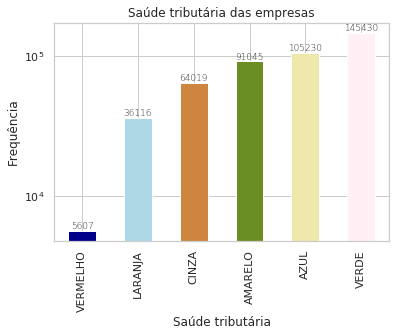

In [260]:
# A maioria das empresas possuem saúde com rotulo verde
graph_barras_abs(market_clean,'de_saude_tributaria','Saúde tributária','Saúde tributária das empresas',4,6)

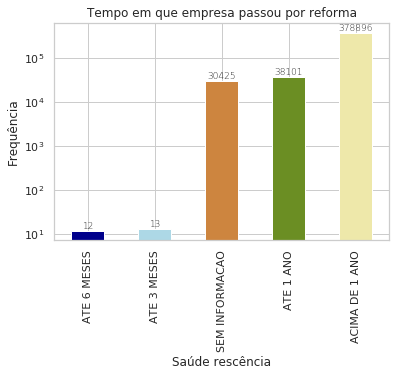

In [261]:
# A maioria das empresas estão acima de um ano do mercado
graph_barras_abs(market_clean,'de_saude_rescencia','Saúde rescência','Tempo em que empresa passou por reforma',4,6)

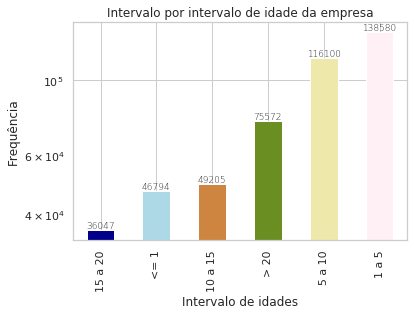

In [308]:
# A maioria das empresas estão acima de um ano do mercado
graph_barras_abs(market_clean,'idade_emp_cat','Intervalo de idades','Intervalo por intervalo de idade da empresa',4,6)

#### Histogramas das varáveis numéricas

In [277]:
def histograma(data,atributo,rotulox,titulo):
    data[atributo].hist(bins=10)
    plt.title(titulo)
    plt.yscale('log')
    plt.xlabel(rotulox)
    plt.show()

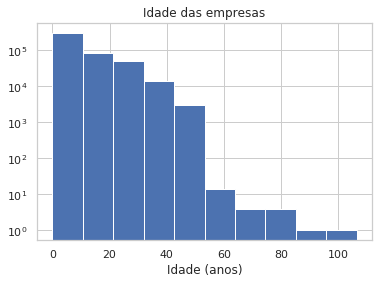

In [278]:
histograma(market_clean,'idade_empresa_anos','Idade (anos)',"Idade das empresas")

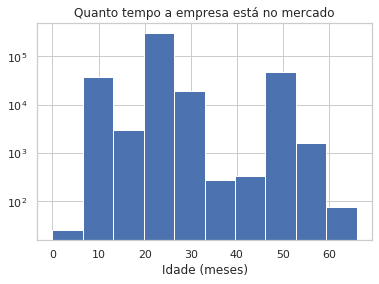

In [279]:
histograma(market_clean,'nu_meses_rescencia','Idade (meses)',"Quanto tempo a empresa está no mercado")

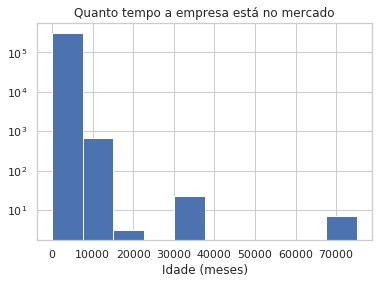

In [280]:
# Verificar
histograma(market_clean,'empsetorcensitariofaixarendapopulacao','Idade (meses)',"Quanto tempo a empresa está no mercado")

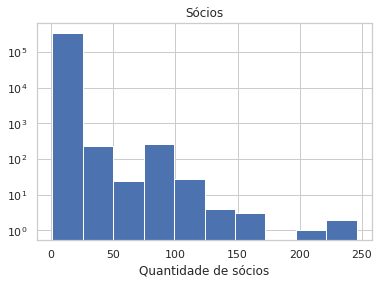

In [281]:
histograma(market_clean,'qt_socios','Quantidade de sócios',"Sócios")

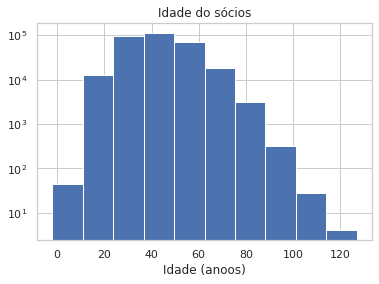

In [282]:
histograma(market_clean,'idade_media_socios','Idade (anoos)',"Idade do sócios")

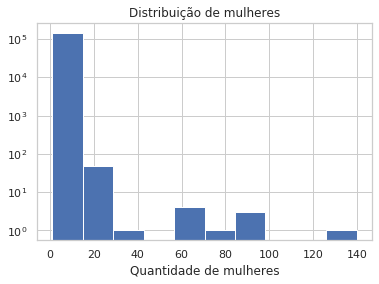

In [283]:
histograma(market_clean,'qt_socios_feminino','Quantidade de mulheres',"Distribuição de mulheres")

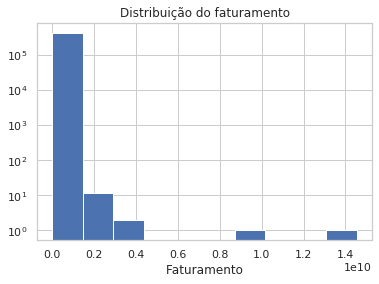

In [284]:
histograma(market_clean,'vl_faturamento_estimado_aux','Faturamento',"Distribuição do faturamento")

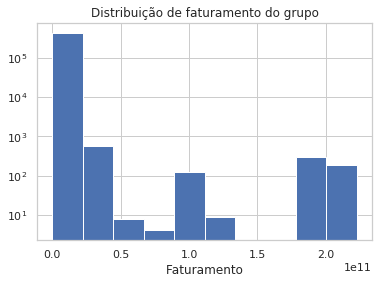

In [286]:
histograma(market_clean,'vl_faturamento_estimado_grupo_aux','Faturamento','Distribuição de faturamento do grupo')

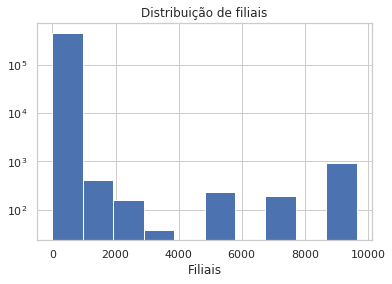

In [287]:
histograma(market_clean,'qt_filiais','Filiais','Distribuição de filiais')

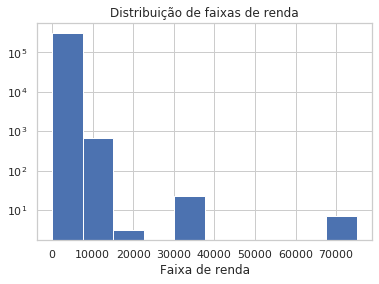

In [311]:
# A maioria dos setores possuem uma renda de no máximo 15 mil reais
histograma(market_clean,'empsetorcensitariofaixarendapopulacao','Faixa de renda','Distribuição de faixas de renda')

### Boxplot

In [295]:
def box_plot(df,atributox,atributoy,titulo,labely,labelx):
    ax = plt.subplots(figsize=(10, 7))
    ax = sns.boxplot(x=atributox,y=atributoy, data=df)
    plt.title(titulo)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.show()

In [309]:
market_clean.dtypes

id                                        object
fl_matriz                                   bool
de_natureza_juridica                      object
sg_uf                                     object
natureza_juridica_macro                   object
de_ramo                                   object
setor                                     object
idade_empresa_anos                       float64
idade_emp_cat                             object
fl_me                                       bool
fl_sa                                       bool
fl_mei                                      bool
fl_ltda                                     bool
dt_situacao                               object
fl_st_especial                              bool
fl_email                                    bool
fl_telefone                                 bool
fl_rm                                       bool
nm_divisao                                object
nm_segmento                               object
fl_optante_simples  

In [306]:
market_clean.idade_emp_cat

0         10 a 15
1           1 a 5
2          5 a 10
3          5 a 10
4           1 a 5
           ...   
462293      1 a 5
462294     5 a 10
462295       > 20
462296      1 a 5
462297       <= 1
Name: idade_emp_cat, Length: 462298, dtype: object

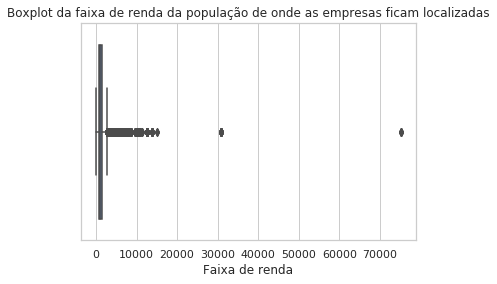

In [312]:
sns.boxplot(x='empsetorcensitariofaixarendapopulacao', data=market_clean)
plt.title("Boxplot da faixa de renda da população de onde as empresas ficam localizadas")
plt.xlabel("Faixa de renda")
plt.show()

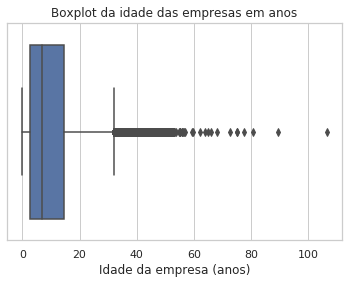

In [305]:
sns.boxplot(x='idade_empresa_anos', data=market_clean)
plt.title("Boxplot da idade das empresas em anos")
plt.xlabel("Idade da empresa (anos)")
plt.show()

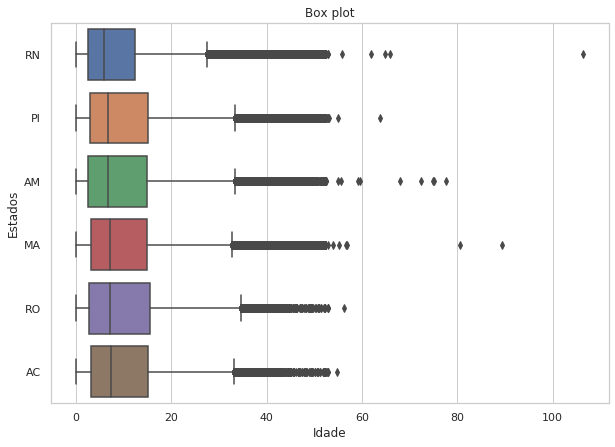

In [297]:
box_plot(market_clean,'idade_empresa_anos','sg_uf','Box plot','Estados','Idade')

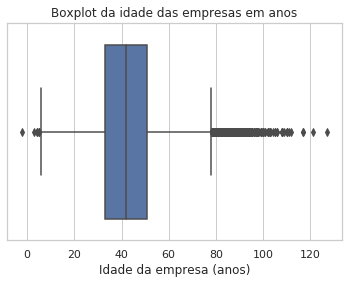

In [366]:
sns.boxplot(x='idade_media_socios', data=market_clean)
plt.title("Boxplot da idade dos sócio em anos")
plt.xlabel("Idade dos sócios (anos)")
plt.show()

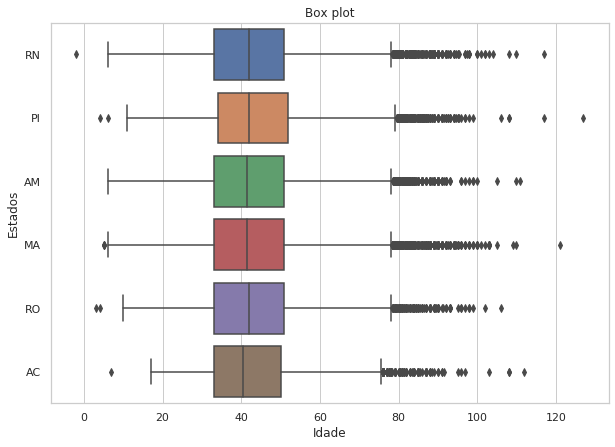

In [365]:
# Não faz sentido pessoas trabalharem com menos de 18 anos e muito menos com mais do que 100
# Solução preencher menores de 18 anos com 18 e maiores do que 70 com 70 (modelo)
box_plot(market_clean,'idade_media_socios','sg_uf','Box plot','Estados','Idade')

In [47]:
# Observando a média das idades
market_clean.idade_media_socios.describe()

count    310696.000000
mean         42.816452
std          12.626447
min          -2.000000
25%          33.000000
50%          42.000000
75%          51.000000
max         127.000000
Name: idade_media_socios, dtype: float64

In [48]:
# Sócios menor do que 18 anos
socio_menor = market_clean[market_clean.idade_media_socios<18]
socio_menor.idade_media_socios.describe()

count    202.000000
mean      13.480611
std        3.804646
min       -2.000000
25%       11.000000
50%       15.000000
75%       17.000000
max       17.500000
Name: idade_media_socios, dtype: float64

In [49]:
# Sócios com mais de 100 anos
socio_maior = market_clean[market_clean.idade_media_socios>80]
socio_maior.idade_media_socios.describe()

count    1517.000000
mean       85.876429
std         5.313722
min        80.142857
25%        82.000000
50%        84.000000
75%        88.000000
max       127.000000
Name: idade_media_socios, dtype: float64

In [50]:
socio_maior_menor = market_clean[(market_clean.idade_media_socios<=80)&(market_clean.idade_media_socios>=18)]
socio_maior_menor.idade_media_socios.describe()

count    308977.000000
mean         42.624217
std          12.266340
min          18.000000
25%          33.000000
50%          42.000000
75%          51.000000
max          80.000000
Name: idade_media_socios, dtype: float64

In [38]:
market_clean.to_csv('market_clean_analise_exploratoria.csv')